<h1 align="left">TSViT Embeddings Experimentation</h1>

<p align="left"><i>PASTIS24 Dataset</i></p>

<p align="left">
  ITESM
  
  <a href="https://www.linkedin.com/in/juanrtato/">Juan Ricardo Albarracin B.</a>
  <br>
  <a href="">Luis Ángel Oporto Añacato.</a>
  <br>
  <a href="">David Alexis García Espinosa.</a>
  <br>
  <b>Last updated:</b> <i>15/05/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>

In [1]:
CONFIG_PATH = '../datalake/config.json'
MODEL_PATH = '../datalake/TSVIT/best.pth'
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))

In [2]:
import ast
import json
import torch
import random
import re
from utils import plot_sample_rgb, plot_seg_mask, mask_to_text
from tsvit import torch_utils, model_architecture
from visiontotext import visiontotextmodel
from pastis24 import get_dataloaders

/home/juanrtato/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_ids = [0]
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)
device = torch_utils.get_device(device_ids, allow_cpu=False)
with open("../datalake/label_names_en.json", "r") as json_file:
    label_names_en = json.load(json_file)
with open("../datalake/colormap.txt", "r") as txt_file:
    colormap = txt_file.readlines()
colormap = [ast.literal_eval(line.strip().rstrip(',')) for line in colormap]

Dataset length: 36375
Dataset length: 12050
../datalake/PASTIS24/pickle24x24/40159_17.pickle
Sample shape: (60, 24, 24, 11)
Sample labels shape: (24, 24, 1)


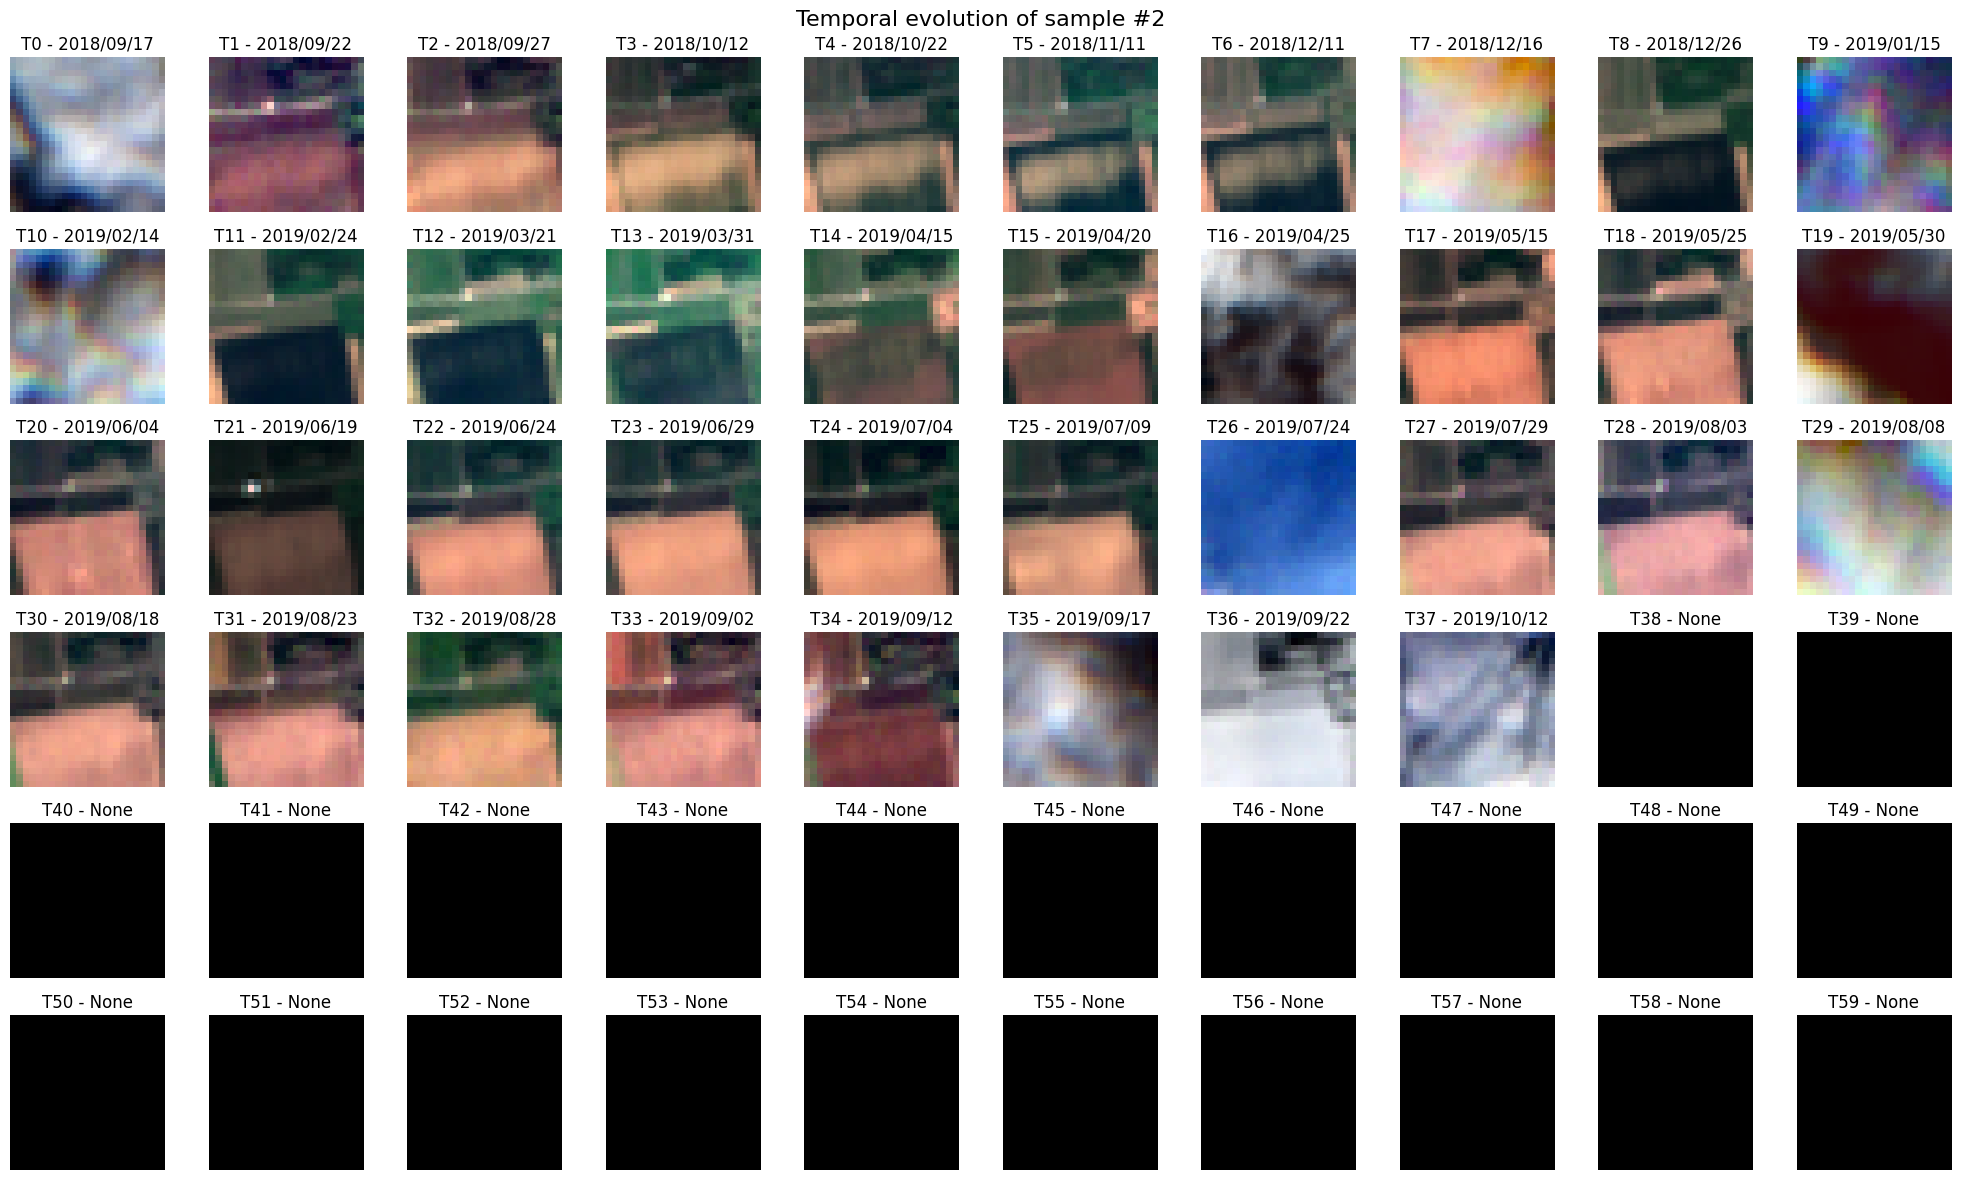

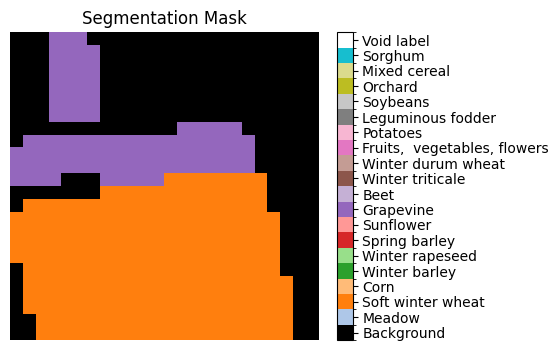

In [4]:
dataloaders = get_dataloaders(config)
sample = next(iter(dataloaders['eval']))
sample_idx = random.randint(0, 16)
patch_id = 'UNKNOWN'
inputs = sample[0]['inputs']
labels = sample[0]['labels']
path_patch = sample[1][sample_idx]
print(path_patch)
match = re.match(r"(\d+)_\d+\.pickle", os.path.basename(path_patch))
if match:
    patch_id = match.group(1)
sample_labels = labels[sample_idx]
plot_sample_rgb(inputs, labels, patch_id, sample_idx=sample_idx)
plot_seg_mask(sample_labels[:, :, 0], colormap, label_names_en)

In [ ]:
model = model_architecture.get_model(config, device)
model.load_state_dict(torch.load(MODEL_PATH))
print(model)

TSViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> (b h w) t (p1 p2 c)', p1=2, p2=2)
    (1): Linear(in_features=40, out_features=128, bias=True)
  )
  (to_temporal_embedding_input): Linear(in_features=366, out_features=128, bias=True)
  (temporal_transformer): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GE

In [6]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[-1.4157, -0.7116,  2.9790,  ..., -1.7636, -0.9332, -0.1302],
         [-0.1289, -0.0418,  3.5818,  ..., -1.2511,  0.1607,  3.5385],
         [-0.0329, -1.2898, -0.0343,  ..., -0.3360, -2.2956, -1.0520],
         ...,
         [ 0.8662, -0.8437, -1.2161,  ..., -1.3557, -1.1494, -1.0445],
         [ 1.1975, -0.6754, -0.8351,  ...,  1.1810,  0.6408,  1.5595],
         [ 0.2207,  0.9584,  1.3030,  ...,  3.4171, -2.8110,  1.5320]]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[-0.1937, -0.9637, -0.3339,  ..., -0.8309,  0.2305,  0.4754],
         [-0.4310, -1.8399, -1.2032,  ..., -0.3691, -3.2671,  1.1410],
         [-0.1313, -0.8199,  0.6495,  ..., -1.4683, -0.0463,  0.6039],
         ...,
         [-1.3100, -1.2888,  0.9349,  ...,  0.9328,  0.3400, -1.3957],
         [-0.0573, -0.1287,  0.4009,  ..., -0.3794,  1.9349,  1.9873],
         [-1.3796, -0.1458, -0.7437,  ..., -0.8470,  1.5899,  1.3612]]],
       device='cuda:0', requ

In [7]:
input_single = inputs[sample_idx]
print('input shape: ', input_single.shape)
input_single = input_single.unsqueeze(0)
print('input shape: ', input_single.shape)
input_single = input_single.to(device)
embeddings = model.get_encoder_embeddings(input_single)
embeddings.shape

input shape:  torch.Size([60, 24, 24, 11])
input shape:  torch.Size([1, 60, 24, 24, 11])


torch.Size([19, 144, 128])

In [8]:
model_vtt = visiontotextmodel.VisionToTextModel(model, decoder_model="gpt2", input_dim=128)
print(model_vtt)

VisionToTextModel(
  (encoder): TSViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b t c (h p1) (w p2) -> (b h w) t (p1 p2 c)', p1=2, p2=2)
      (1): Linear(in_features=40, out_features=128, bias=True)
    )
    (to_temporal_embedding_input): Linear(in_features=366, out_features=128, bias=True)
    (temporal_transformer): Transformer(
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=128, out_features=384, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (

In [9]:
"""model_vtt.eval()
model_vtt = model_vtt.to(device)
embeddings = embeddings.to(device)
with torch.no_grad():
    outputs = model_vtt(embeddings)
generated_ids = torch.argmax(outputs, dim=-1)
generated_text = model_vtt.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)"""

'model_vtt.eval()\nmodel_vtt = model_vtt.to(device)\nembeddings = embeddings.to(device)\nwith torch.no_grad():\n    outputs = model_vtt(embeddings)\ngenerated_ids = torch.argmax(outputs, dim=-1)\ngenerated_text = model_vtt.tokenizer.decode(generated_ids[0], skip_special_tokens=True)\nprint(generated_text)'

In [10]:
def generate_caption(model, input_single, prompt="An image of"):
    model.eval()
    model = model.to(device)
    input_single = input_single.to(device)

    with torch.no_grad():
        visual_emb = model.encoder.get_encoder_embeddings(input_single)
        print('visual_emb shape: ', visual_emb.shape)

        visual_cls = visual_emb[:, -1, :] # cls token?
        visual_proj = model.projector(visual_cls).unsqueeze(1)
        print('visual_proj shape: ', visual_proj.shape)

        input_ids = model.tokenizer(prompt, return_tensors="pt", padding=True).input_ids.to(device)
        input_ids = input_ids.expand(visual_cls.shape[0], -1)
        text_emb = model.decoder.transformer.wte(input_ids)
        print('text_emb shape: ', text_emb.shape)

        input_emb = torch.cat([visual_proj, text_emb], dim=1)

        # Construir attention_mask
        visual_attention_mask = torch.ones(visual_proj.size()[:-1], dtype=torch.long).to(device)  # [B, 1]
        text_attention_mask = (input_ids != model.tokenizer.pad_token_id).long()  # [B, T]
        attention_mask = torch.cat([visual_attention_mask, text_attention_mask], dim=1)  # [B, 1 + T]

        # Definir pad_token_id
        pad_token_id = model.tokenizer.pad_token_id
        if pad_token_id is None:
            pad_token_id = model.tokenizer.eos_token_id

        outputs = model.decoder.generate(
            inputs_embeds=input_emb,
            attention_mask=attention_mask,
            max_length=30,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1,
            pad_token_id=pad_token_id
        )

    return model.tokenizer.decode(outputs[0], skip_special_tokens=True)

prompt = "The image displays the crop of "
caption = generate_caption(model_vtt, input_single, prompt)

visual_emb shape:  torch.Size([19, 144, 128])
visual_proj shape:  torch.Size([19, 1, 768])
text_emb shape:  torch.Size([19, 7, 768])


In [11]:
input_single.shape

torch.Size([1, 60, 24, 24, 11])

In [12]:
print(caption)

ichthyophilus on the right. The background image is only used as a base for the background color.
